# [3-tuning] - Parametrages de hyperparamètres

## Import des modules

In [ ]:
import io
import os
import boto3
import joblib
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

## Connection à AWS S3

In [2]:
# Configutations S3 access and data
load_dotenv()
aws_access_key_id = os.getenv('aws_access_key_id')
aws_secret_access_key = os.getenv('aws_secret_access_key')

In [3]:
# S3 connection
s3 = boto3.client(
    service_name = "s3",
    region_name = "eu-west-3",
    aws_access_key_id = aws_access_key_id,
    aws_secret_access_key = aws_secret_access_key,
)

## Import du jeu de données

In [4]:
# Specific bucket data
bucket_name = "hotel-resa-prediction"
prefix = "datasets/"
filename = "processed_hotel_bookings.csv"

In [5]:
# get datas 
result = s3.list_objects(Bucket=bucket_name)
for obj in result.get('Contents'):
    if (obj["Key"].startswith(prefix)) and (obj["Key"].endswith(filename)):
        data = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        contents = data['Body'].read().decode("utf-8")
        data = pd.read_csv(io.StringIO(contents), low_memory=False)

In [6]:
X = data.drop("is_canceled",  axis=1)
y = data["is_canceled"]
print("Features : ", X.shape)
print("Target : ", y.shape) # s'assurer de n'avoir qu'une colonne ici

Features :  (119210, 30)
Target :  (119210,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    shuffle=True, 
    stratify=y # IMPORTANT pour bien balancer les prédictions première itération --> courbe ROC mauvais 
)
print("Features train : ", X_train.shape)
print("Target train : ", y_train.shape)
print("Features test : ", X_test.shape)
print("Target test : ", y_test.shape)

Features train :  (83447, 30)
Target train :  (83447,)
Features test :  (35763, 30)
Target test :  (35763,)


## Import du modèle pré-entrainé dans le cloud

In [8]:
prefix_model = "models/"
filename_model = "hotel_bookings_churn_model.pkl"

In [9]:
result_model = s3.list_objects(Bucket=bucket_name)
for obj in result_model.get('Contents'):
    if (obj["Key"].startswith(prefix_model)) and (obj["Key"].endswith(filename_model)):
        model = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        model_content = model['Body'].read()
        model_pipeline = joblib.load(io.BytesIO(model_content))

## Affinage du modèle
> Paramétrage du modèle pour utiliser un seul cœur (njobs) pour passer le multi-cœur dans le GridSeach;
> Parametrage du verbose pour qu'on affiche les messages durant l'entraînement et prédiction. 

In [10]:
model_pipeline

,steps,"[('columntransformer', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
params_distrib = {
    "gradientboostingclassifier__n_estimators": [100, 200, 300],
    "gradientboostingclassifier__max_depth": [3, 5, 7],
    "gradientboostingclassifier__learning_rate": [0.05, 0.1, 0.2],
    "gradientboostingclassifier__subsample": [0.8, 1.0],
    "gradientboostingclassifier__max_features": ["sqrt", None],
    "gradientboostingclassifier__min_samples_split": [5, 10],
    "gradientboostingclassifier__min_samples_leaf": [1, 5]
}

**Info** : Validation croisée avec paraléllisation et 3 cv. 

In [12]:
search_cv = RandomizedSearchCV(
    model_pipeline,
    param_distributions=params_distrib,
    n_iter=50,  
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    error_score='raise'
)

In [13]:
search_cv.fit(X_train, y_train) 

Fitting 3 folds for each of 50 candidates, totalling 150 fits


,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'gradientboostingclassifier__learning_rate': [0.05, 0.1, ...], 'gradientboostingclassifier__max_depth': [3, 5, ...], 'gradientboostingclassifier__max_features': ['sqrt', None], 'gradientboostingclassifier__min_samples_leaf': [1, 5], ...}"
,n_iter,50
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,'raise'


In [14]:
cv_results = search_cv.cv_results_ 

In [15]:
pd.DataFrame(cv_results).sort_values(by="rank_test_score", ascending=True).head(3) 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__subsample,param_gradientboostingclassifier__n_estimators,param_gradientboostingclassifier__min_samples_split,param_gradientboostingclassifier__min_samples_leaf,param_gradientboostingclassifier__max_features,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,179.679283,1.026761,1.746729,0.241010,0.8,300,5,5,None,7,0.2,"{'gradientboostingclassifier__subsample': 0.8,...",0.873957,0.872340,0.878806,0.875034,0.002748,1
20,161.831660,1.770651,1.713367,0.097976,0.8,300,10,5,None,7,0.1,"{'gradientboostingclassifier__subsample': 0.8,...",0.872340,0.871189,0.875175,0.872901,0.001675,2
19,159.982683,0.650914,1.372904,0.020630,0.8,300,5,5,None,7,0.1,"{'gradientboostingclassifier__subsample': 0.8,...",0.872519,0.871117,0.875067,0.872901,0.001635,3


In [16]:
best_model = search_cv.best_estimator_
best_model

,steps,"[('columntransformer', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
result = best_model.predict(X_test) 

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

accuracy = accuracy_score(y_test, result)
precision = precision_score(y_test, result)
recall = recall_score(y_test, result)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [31]:
print(f"The accuracy score : {accuracy*100:.3f}%")
print(f"The precision score: {precision*100:.3f}%")
print(f"The recall score: {recall*100:.3f}%")
print(f"The ROC AUC score: {roc_auc*100:.3f}%")

The accuracy score : 87.988%
The precision score: 86.041%
The recall score: 80.694%
The ROC AUC score: 94.885%


In [35]:
confusion_matrix = confusion_matrix(y_test, result) 

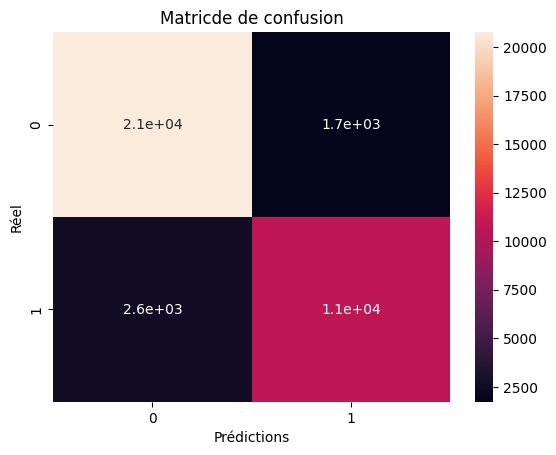

In [38]:
_ = sns.heatmap((confusion_matrix), annot=True).set(title="Matricde de confusion", xlabel="Prédictions", ylabel="Réel") 

/var/folders/6j/prwx2hms3hzdtbw453ddk_k40000gn/T/ipykernel_7576/422342057.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


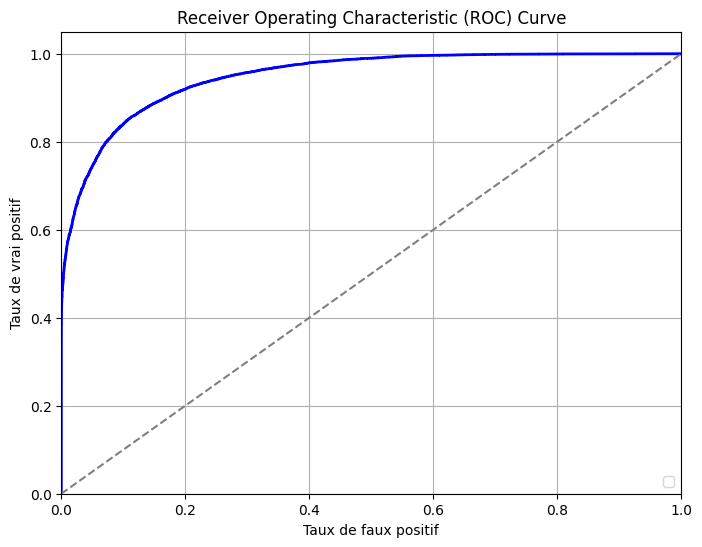

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Taux de faux positif")
plt.ylabel("Taux de vrai positif")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

-- END --